In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
%matplotlib inline

sns.set(font_scale = 1.3)

In [2]:
DATA_PATH = 'https://raw.githubusercontent.com/xiaodan-zhou/covid_wildfire/master/data/moddat_Feb2021.csv'

In [3]:
data = pd.read_csv(DATA_PATH, parse_dates=['date'])

In [4]:
data['date'] = data['date'].dt.date
sorted_by_date = data.sort_values('date')
no_of_days = len(sorted_by_date['date'].unique())
starting_date = sorted_by_date['date'].iloc[0]
ending_date = sorted_by_date['date'].iloc[-1]
print(f'The data covers {no_of_days} days in total, starting from {starting_date} to {ending_date}')

The data covers 277 days in total, starting from 2020-03-15 to 2020-12-16


In [53]:
print(f"Number of states in the data are {len(data['State'].unique())}")

Number of states in the data are 3


In [52]:
print(f"Number of counties in the data are {len(data['County'].unique())}")

Number of counties in the data are 88


In [5]:
data.columns

Index(['FIPS', 'date', 'cases', 'cumu_cases', 'deaths', 'cumu_deaths',
       'population', 'pm25', 'Long', 'Lat', 'tmmx', 'rmax', 'sph', 'hazardmap',
       'relative_change_feb', 'ratio_travelers', 'month', 'day', 'md',
       'pm25_history_raw', 'County', 'State', 'StateFIPS', 'dayofweek',
       'date_num', 'date_str', 'pm25_history', 'pm25_raw', 'wildfire',
       'pm_wildfire', 'pm_ambient'],
      dtype='object')

##### Columns in the data and my interpretations of what they mean in the physical world  (Note: This section took a bulk of time)

First, in order to fully digest the data, I have defined the physical meanings of columns in the dataset (.csv) below. To arrive at this definitions, since the column names are not intuitively relatable in certain cases, I had to go through the codebase to find where those columns have been created and then traceback to things like the data sources and online. documentations of those data sources.

- **FIPS**: FIPS codes are numbers which uniquely identify geographic areas (Contains pointers to state and county)
- **Date**: Data of observation
- **Cases**: COVID-19 cases recorded on the date
- **cumu_cases**: (NOT YET UNDERSTOOD). Related to lagged values in some sense. Not documented in code.
- **deaths**: COVID-19 deaths
- **cumu_deaths**: (NOT YET UNDERSTOOD). Related to lagged values in some sense. Not documented in code.
- **population**: Population (Number of persons) in county obtained from GPWv411: Population Count (Gridded Population of the World Version 4.11 [**link**](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_Population_Count)
- **pm25**: amount of PM2.5 measured per country on assigned date
- **Long**: Longitude
- **Lat**: Latitude
- **tmmx**: Maximum temperature measured in Celcius obtained from University of Idaho Gridded Surface Meteorological Dataset [**link**](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET)
- **rmax**: Maximum relative humidity obtained from University of Idaho Gridded Surface Meteorological Dataset [**link**](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET)
- **sph**: Specific humidity (kg/kg) obtained from University of Idaho Gridded Surface Meteorological Dataset [**link**](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET)
- **hazardmap**: Hazard data from HMS hazard and smoke product, [link](https://www.ospo.noaa.gov/Products/land/hms.html#maps). Meaning: 0=nosmoke, 5=light, 16=medium, 27=heavy. Wildfire days are chosen as days with hazardmap column values = 27
- **relative_change_feb**: Mobility proxy obtained from Facebook movement range data [link](https://dataforgood.facebook.com/dfg/tools/movement-range-maps). This variable is annotated as `all_day_bing_tiles_visited_relative_change`in the original data (not included in the repository). This can be interpretated as number of $600m^2$ tiles seen by the average person in a day.
- **ratio_travelers**: Mobility proxy obtained from Facebook movement range data [link](https://dataforgood.facebook.com/dfg/tools/movement-range-maps). This variable is annotated as `all_day_ratio_single_tile_users`in the original data (not included in the repository). This can be interpreted as proportion of people with low mobility on the day (single tile users. A tile is $600m^2$)
- **month**: Calender month of the year
- **day**: day of the month
- **md**: month-day
- **pm25_history_raw**: Historical PM2.5 values for counterfactual checking in the study
- **County**: County name
- **State**: State: 'CA', 'OR', or 'WA' -> California, Oregon, or Washington
- **StateFIPS**: FIPS code for state
- **dayofweek**: Day of the week, i.e Monday, Tuesday, etc
- **pm25_history**: Historical PM2.5 values for counterfactual checking in the study

Verify that there are seven days of the week only in the data

In [6]:
print('Days of the week in the data are \n', list(data['dayofweek'].unique()))

Days of the week in the data are 
 ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


Verify that there are three states only in the data

In [7]:
print('States in the data are', list(data['State'].unique()))

States in the data are ['CA', 'OR', 'WA']


Verify that **hazardmap** variable has been used to construct the **windfire** (i.e Wildfire days) variable

In [8]:
data[data['wildfire']==True][['hazardmap','wildfire']].head()

,hazardmap,wildfire
599,27.0,True
1847,27.0,True
1939,27.0,True
1955,27.0,True
6190,27.0,True


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25484 entries, 0 to 25483
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 25484 non-null  int64  
 1   date                 25484 non-null  object 
 2   cases                25317 non-null  float64
 3   cumu_cases           25484 non-null  int64  
 4   deaths               25318 non-null  float64
 5   cumu_deaths          25484 non-null  int64  
 6   population           25484 non-null  int64  
 7   pm25                 25484 non-null  float64
 8   Long                 25234 non-null  float64
 9   Lat                  25234 non-null  float64
 10  tmmx                 25484 non-null  float64
 11  rmax                 25484 non-null  float64
 12  sph                  25484 non-null  float64
 13  hazardmap            23644 non-null  float64
 14  relative_change_feb  23822 non-null  float64
 15  ratio_travelers      23822 non-null 

##### Number of missing data per variable (column in source data

In [10]:
data.isna().sum()

FIPS                      0
date                      0
cases                   167
cumu_cases                0
deaths                  166
cumu_deaths               0
population                0
pm25                      0
Long                    250
Lat                     250
tmmx                      0
rmax                      0
sph                       0
hazardmap              1840
relative_change_feb    1662
ratio_travelers        1662
month                     0
day                       0
md                        0
pm25_history_raw        206
County                    0
State                     0
StateFIPS                 0
dayofweek                 0
date_num                  0
date_str                  0
pm25_history            206
pm25_raw                250
wildfire                  0
pm_wildfire               0
pm_ambient                0
dtype: int64

- Cases data are missing on 167 days
- Deaths data are missing on 166 days
- Geospatial annotations (Lat, Long) are missing for 250 days
- PM2.5 data are missing for 250 days in 2020, and 206 days in the historical (counterfactual use case) data
- hazardmap data are missing for 1840 days. This could mean that the wildfire days selection is incomplete and would require supplementary data

Missing data can be dealt with in a number of ways: removal, interpolation, inputting values on same day in previous years (a mean or median over a couple of years, etc)

Since population values only vary spatially across counties and states, it is useful to build a table that maps population to country and states. This table will facilitate easy computation of per capital versions of difference variables.

# 2.0 Population 

In [11]:
population_state_county = data.groupby(['State', 'County']).sample(1)[['State', 'County','population']].reset_index(drop=True)
population_state_county.head()

,State,County,population
0,CA,Alameda County,1671329
1,CA,Butte County,219186
2,CA,Calaveras County,45905
3,CA,Colusa County,21547
4,CA,Contra Costa County,1153526


In [12]:
population_state = population_state_county.groupby('State').sum().reset_index()
population_state.head()

,State,population
0,CA,38421250
1,OR,2922402
2,WA,7480371


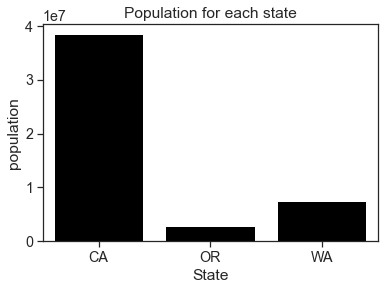

In [13]:
sns.set_style(style="ticks")
ax = sns.barplot(x='State', y="population", data=population_state, color='black')
plt.title('Population for each state')
plt.show()

- It can be seen that there is is wide difference in population for the state of California compared to other considered states. The inclusion of population (or population related variables like population density) thus could be useful for this study.

# 2.0  Covid 19 data exploration

- Total cases/deaths per state 
- Distribution of cases/deaths in each county per state
- Time series (sum) for each state
- Time series (sum) for counties with highest death
- Time series for top 5 county ranked by sum of cases/deaths, colored by wildfire days

### Total cases/deaths per state

In [14]:
data_state = data.groupby('State')[['cases','deaths']].sum().reset_index()

data_state = data_state.merge(right= population_state, how='left', on='State')

In [15]:
data_state

,State,cases,deaths,population
0,CA,1655032.0,21644.0,38421250
1,OR,72551.0,940.0,2922402
2,WA,201928.0,3070.0,7480371


In [16]:
# Compute cases per capita and deaths per capita
data_state['cases_per_capita'] = data_state['cases']/ data_state['population']
data_state['deaths_per_capita'] = data_state['deaths']/ data_state['population']

###### Obtain plots

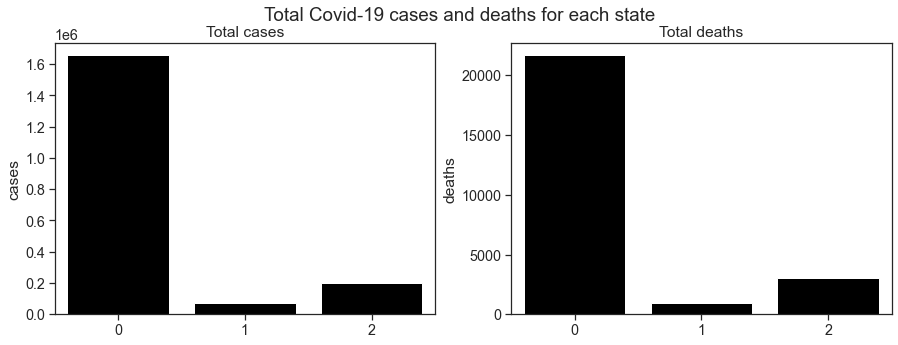

In [17]:
#fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Total Covid-19 cases and deaths for each state')
sns.barplot(ax = axes[0], x=data_state.index, y="cases", data=data_state, color='black')
axes[0].set_title('Total cases')
sns.barplot(ax = axes[1], x=data_state.index, y="deaths", data=data_state, color='black')
axes[1].set_title('Total deaths')
plt.show()

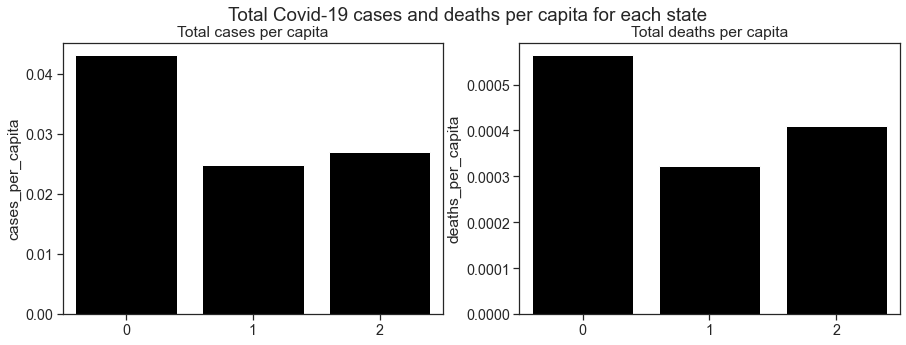

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Total Covid-19 cases and deaths per capita for each state')
sns.barplot(ax = axes[0], x=data_state.index, y="cases_per_capita", data=data_state, color='black')
axes[0].set_title('Total cases per capita')
sns.barplot(ax = axes[1], x=data_state.index, y="deaths_per_capita", data=data_state, color='black')
axes[1].set_title('Total deaths per capita')
plt.show()

- It can be seen here that the vert large difference between cases and deaths in California compared to the remaining states could be attributable to larger population in California. Since person-to-person contact is the major transmission mechanism for Covid-19, more can be siad to result in more transmission of the virus (in a non-linear way) among the population.
- California has the highest total cases, followed by Washington

### Total cases/deaths and population per county per state

In [19]:
# Helper functions

def get_top_counties_per_state(state: str, factor: str, n: int):
    
    """
    get top n counties
    
    state (str): WA, CA or OR
    factor (str): population, deaths or cases
    n(int): select top n based on ranking by factor
    
    """
    data_state = data[data['State']==state]
    
    assert factor in ('population', 'deaths', 'cases'), 'Ranking should be perfomed on one of deaths, population, and cases'
    if factor != 'population':
        data_state = data_state.groupby('County')[[factor]].sum().reset_index()
        top_counties = data_state.sort_values(factor, ascending=False)
    else:
        top_counties = population_state_county.sort_values(factor, ascending=False)
    return list(top_counties['County'])[:n]

def plot_top_counties_distribution(state: str, factor: str, n: int=10):
    
    """
    Plot total cases/deaths per county
    """
    
    top_n_counties = get_top_counties_per_state(state, factor, n=n)
    top_data_state = data[data['County'].isin(top_n_counties)]
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharey=True)
    fig.suptitle(f'Distribution of Covid-19 cases and deaths for top {n} counties with highest {factor} in {state} state')
    sns.boxplot(ax = axes[0], y='County', x='cases', orient='h', data=top_data_state)
    axes[0].set_title('Cases')
    sns.boxplot(ax = axes[1], y='County', x='deaths', orient='h', data=top_data_state)
    axes[1].set_title('deaths')
  
    plt.show()

    

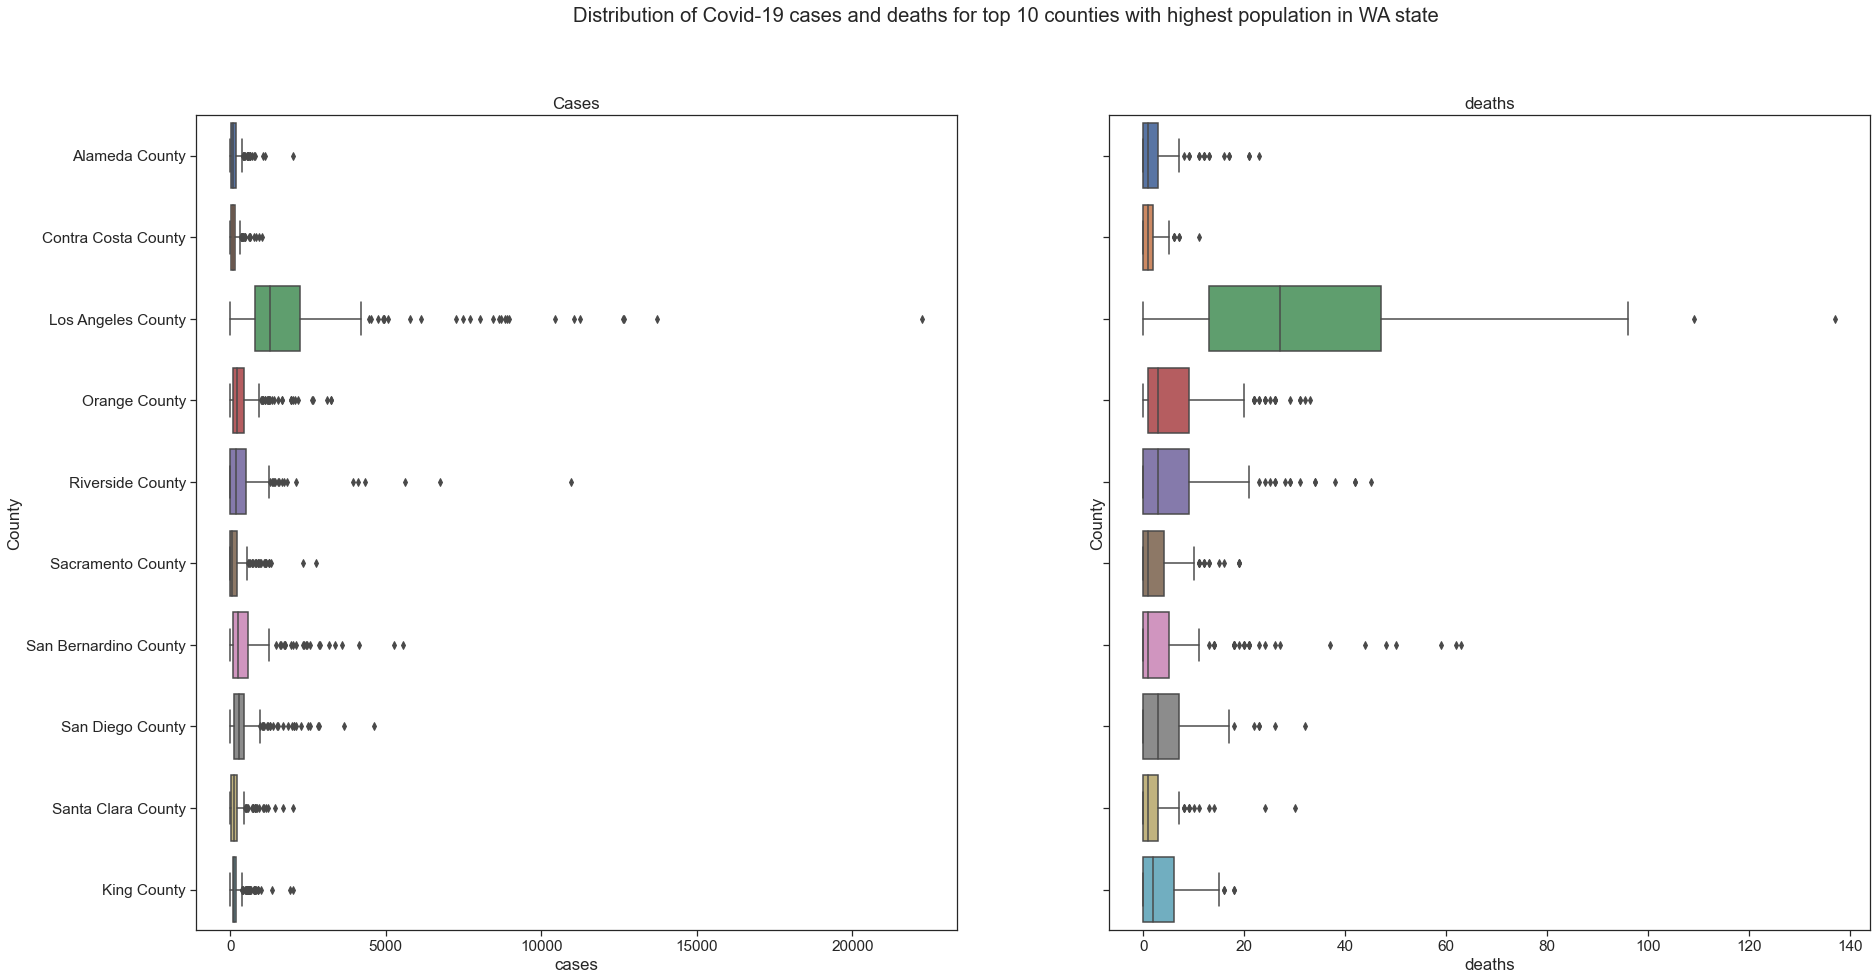

In [20]:
sns.set(font_scale = 1.4)
sns.set_style(style="ticks")
## Note you can change 'factor' in the function called below to ['deaths', 'cases', 'population']
plot_top_counties_distribution('WA', factor='population')

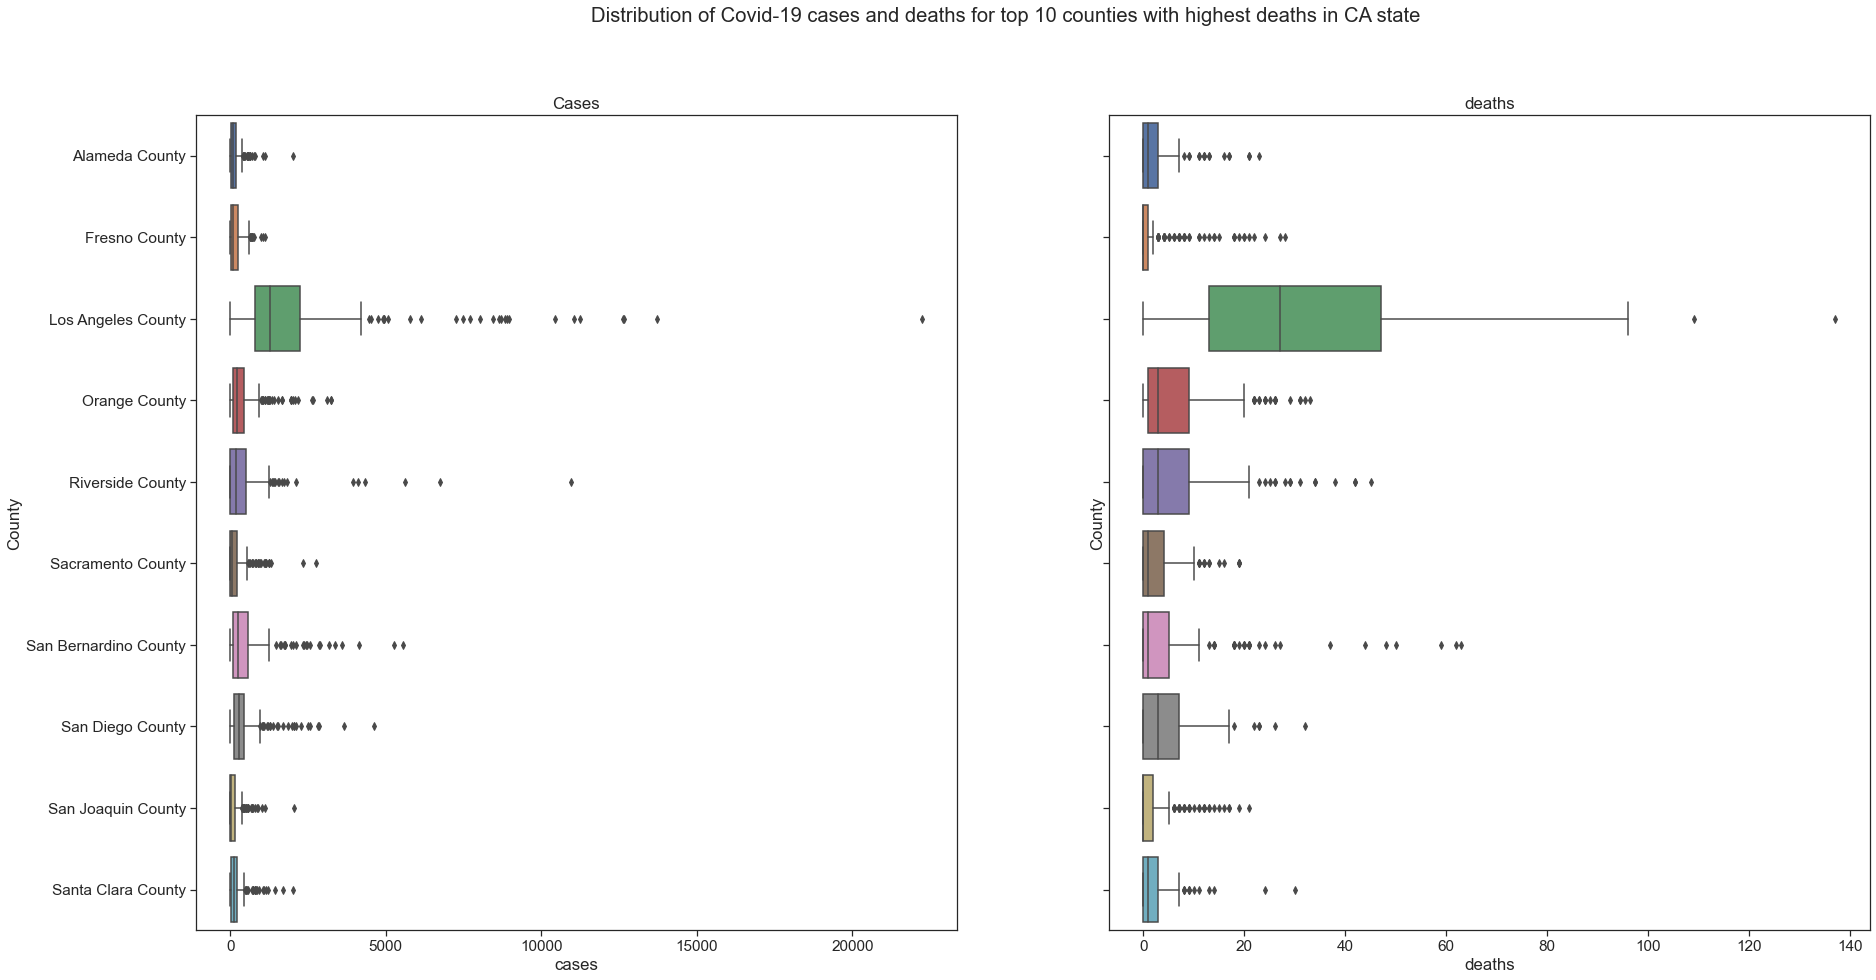

In [21]:
## Note you can change 'factor' in the function called below to ['deaths', 'cases', 'population']
plot_top_counties_distribution('CA', factor='deaths')

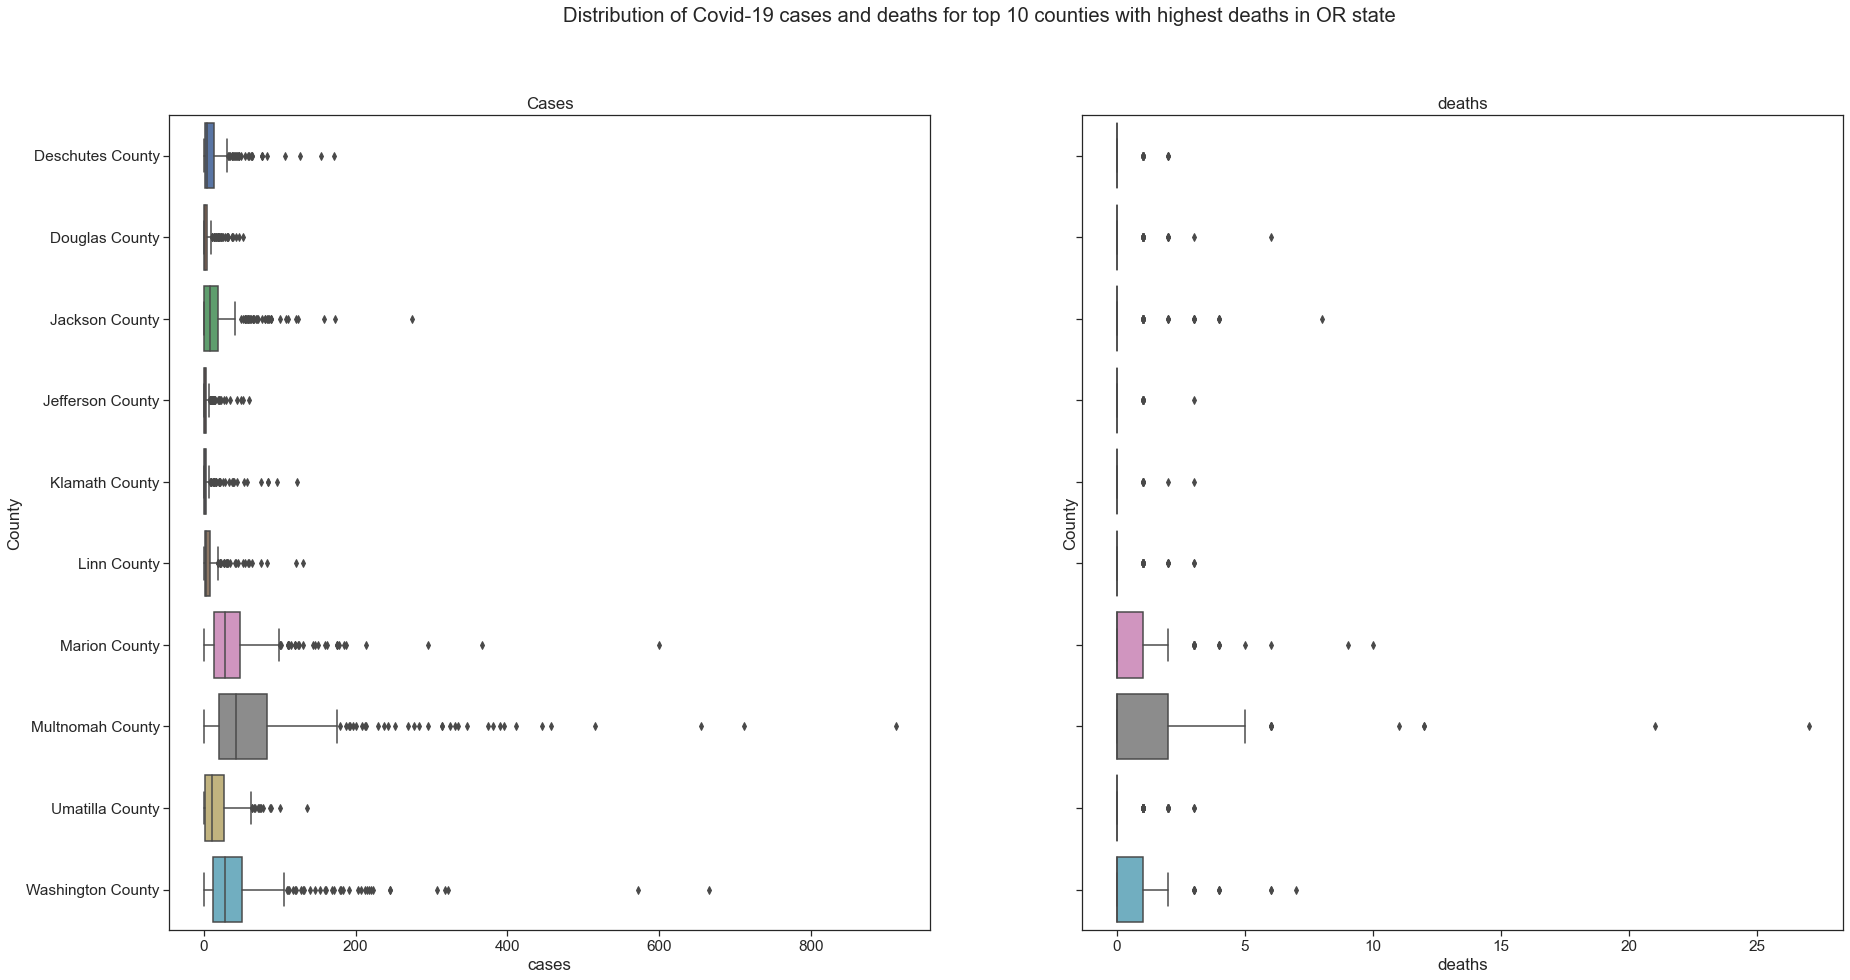

In [22]:
plot_top_counties_distribution('OR', factor='deaths')

Observation
- For the case of deaths, as can be seen, the Covid death data looks sparse. There is also a significant amount of zero values in the **cases** data. It should be noted that this data doesn't account for factors including testing rate, test coverage and capabilities across the different counties.

- The data shows spatial heterogeneity in cases and deaths across different counties

In [23]:
non_zero_death = data[data['deaths'] > 0.0]

print(f'There are only about {round((len(non_zero_death) / len(data)) * 100, 2)}% nonzero death days reported in the data \n across all sites considered. Sparsity thus should be an important consideration for this study') 

There are only about 20.99% nonzero death days reported in the data 
 across all sites considered. Sparsity thus should be an important consideration for this study


In [24]:
non_zero_cases = data[data['cases'] > 0.0]

print(f'There are only about {round((len(non_zero_cases) / len(data)) * 100, 2)}% nonzero cases day reported in the data \n across all sites considered. Sparsity thus should be an important consideration for this study') 

There are only about 67.58% nonzero cases day reported in the data 
 across all sites considered. Sparsity thus should be an important consideration for this study


### Time series (sum) for each state

In [25]:
def plot_time_series_for_state(state:str, to_plot: List=['cases', 'deaths']):
    data_state = data[data['State']==state]
    data_per_day = data_state.groupby('date').sum().reset_index()

    fig, axes = plt.subplots(1, len(to_plot), figsize=(15, 7))
    fig.suptitle(f'Total sum of reported {to_plot} per day in {state} state')
    
    if len(to_plot) > 1:
        for i, ax in enumerate(axes.flat):
            sns.lineplot(ax=axes[i],data=data_per_day, x='date', y=to_plot[i], color= 'black')
            ax.set_title(to_plot[i])
            ax.tick_params(labelrotation=45)
    else:
        sns.lineplot(ax=axes,data=data_per_day, x='date', y=to_plot[0], color= 'black')
        axes.set_title(to_plot[0])
        axes.tick_params(labelrotation=45)
    
    plt.show()

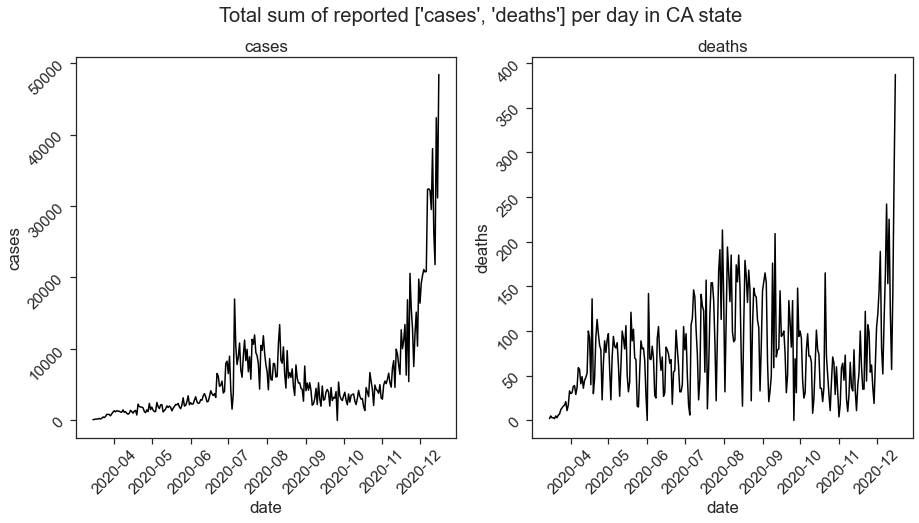

In [26]:
plot_time_series_for_state('CA')

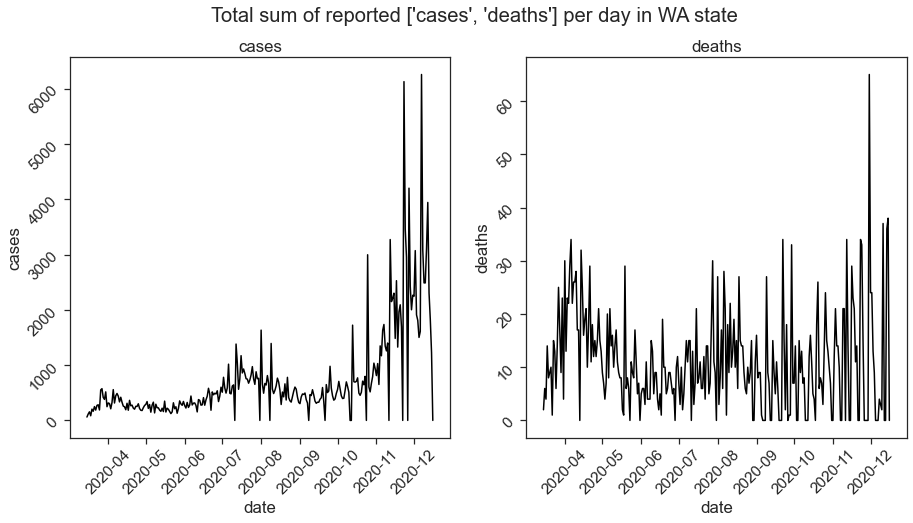

In [27]:
plot_time_series_for_state('WA')

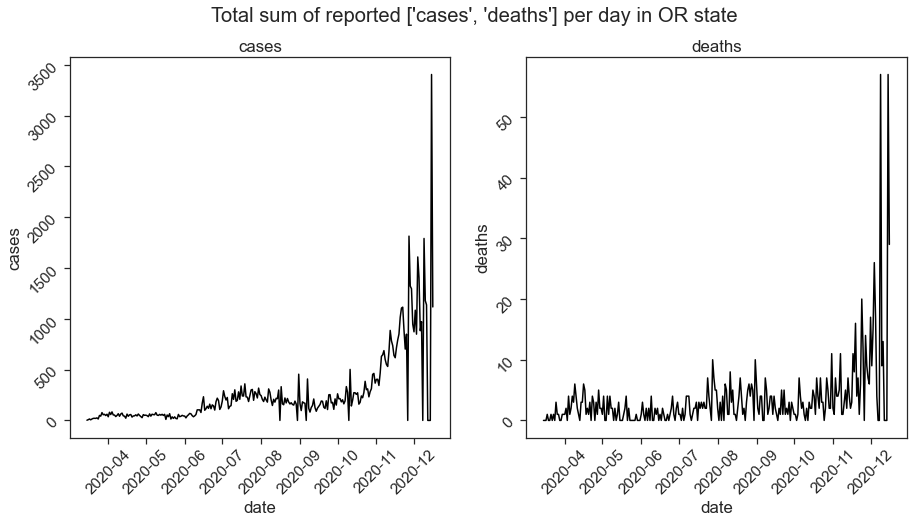

In [28]:
plot_time_series_for_state('OR')

Observation:

- These figures suggest the preence of waves in the data. For example, around July- August, and around December, there are waves of increasing reported cases and deaths. It should be noted however that in 2020, the testing capability in different locations ramped up as the year went by and governments were able to fulfil the logistical and polical demands of making test accessible at scale. This effect might play some role in the behaviour the data.

### Time series of cases/deaths for top county ranked by sum of cases/deaths/population

In [29]:


def get_top_counties(factor: str, n: int):
    
    """
    get top n counties
    
    state (str): WA, CA or OR
    factor (str): population, deaths or cases
    n(int): select top n based on ranking by factor
    
    """
    
    assert factor in ('population', 'deaths', 'cases'), 'Ranking should be perfomed on one of deaths, population, and cases'
    if factor != 'population':
        data_state = data.groupby('County')[[factor]].sum().reset_index()
        top_counties = data_state.sort_values(factor, ascending=False)
    else:
        top_counties = population_state_county.sort_values(factor, ascending=False)
    return list(top_counties['County'])[:n]

def plot_top_counties_time_series(factor: str, n: int=5, to_plot=['cases', 'deaths'], sharey=False, background=None):
    
    """
    
    state (str): WA, CA or OR
    factor (str): population, deaths or cases, used for ranking
    n(int): select top n based on ranking by factor
    to_plot: variables to plot
    
    """
    
    top_n_counties = get_top_counties(factor, n=n)
    top_data_state = data[data['County'].isin(top_n_counties)]
    
    
    
    #fig.suptitle(f'Distribution of Covid-19 cases and deaths for top {n} counties with highest {factor} in {state} state')
    
    
    for county in top_n_counties:
        series_county = top_data_state[top_data_state['County'] == county]
        fig, axes = plt.subplots(1, len(to_plot), figsize=(15, 7), sharey=sharey)
        
        if len(to_plot) > 1:
            for i, ax in enumerate(axes.flat):
                sns.lineplot(ax = ax, x='date', y=to_plot[i], linestyle='', hue='wildfire', data=series_county, marker='o')
                ax.set_title(f'{to_plot[i]} in {county}')
                ax.tick_params(labelrotation=45)
        else:
            sns.lineplot(ax = axes, x='date', y=to_plot[0], linestyle='', hue='wildfire', data=series_county, marker='o')
            axes.set_title(f'{to_plot[0]} in {county}')
            axes.tick_params(labelrotation=45)

        plt.show()

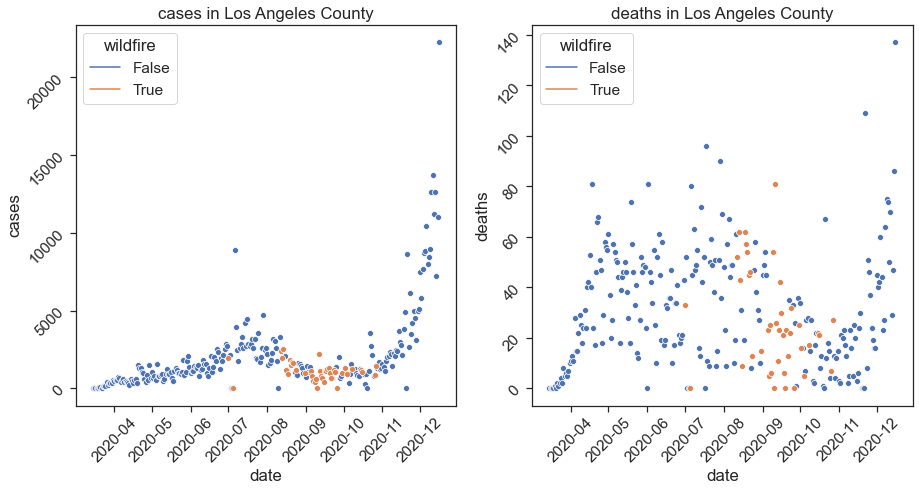

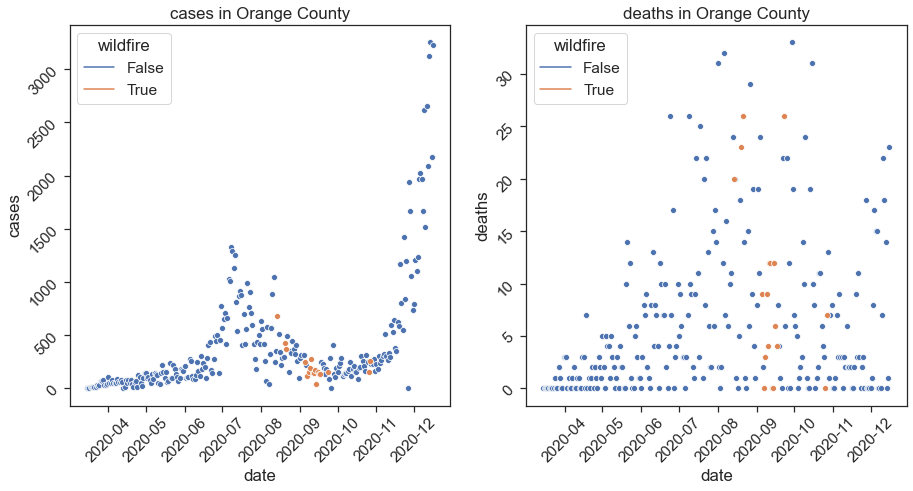

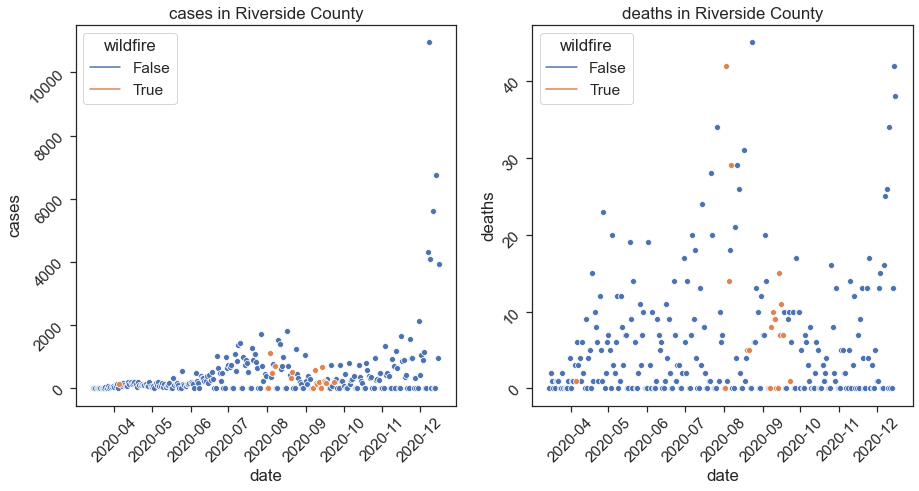

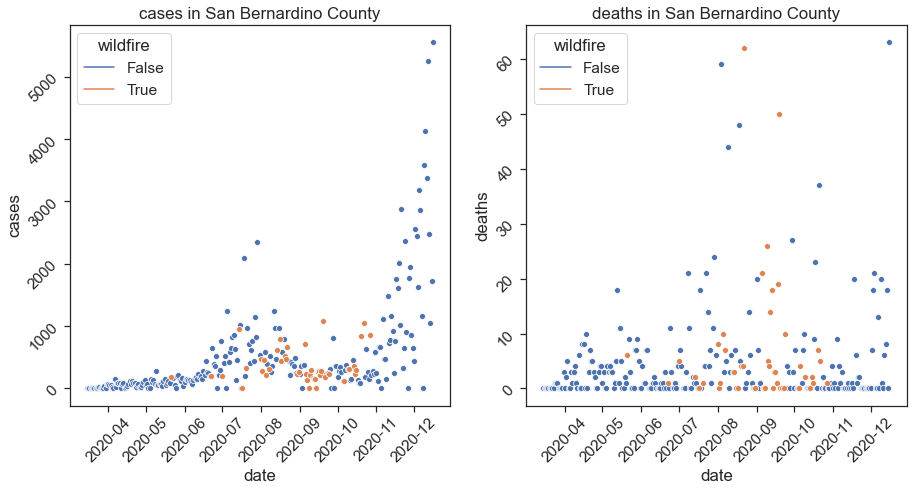

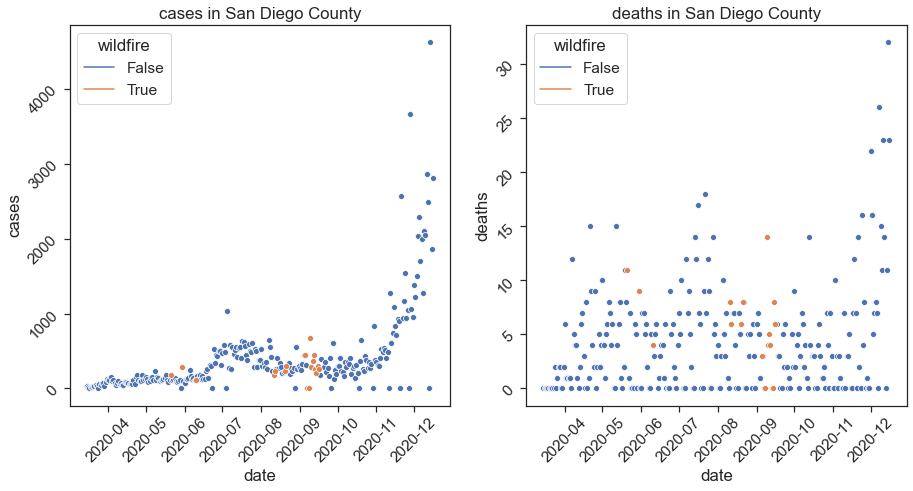

In [30]:
plot_top_counties_time_series('deaths')

In the series of plots immediately following above, the points colored orange are wildfire days. 

# 3.  PM2.5 Data

### Time series (sum) of PM2.5 values for each state

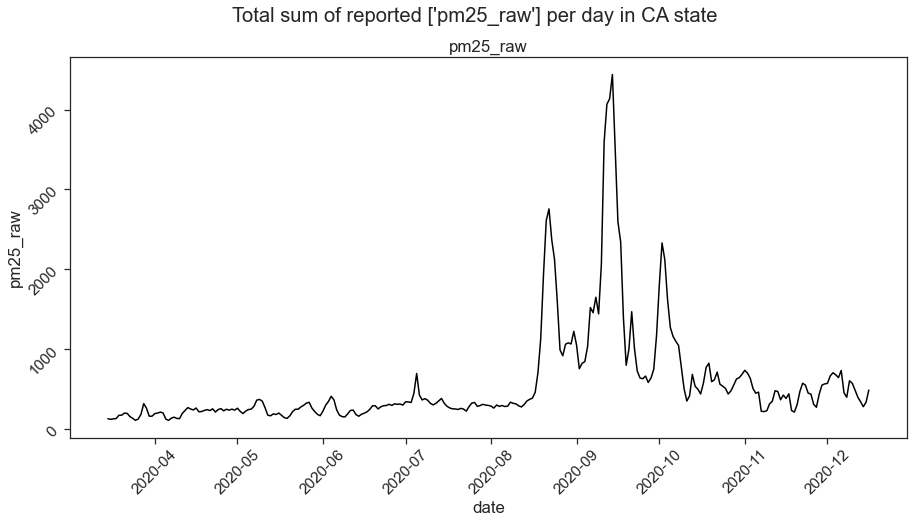

In [31]:
plot_time_series_for_state('CA', to_plot=['pm25_raw'])

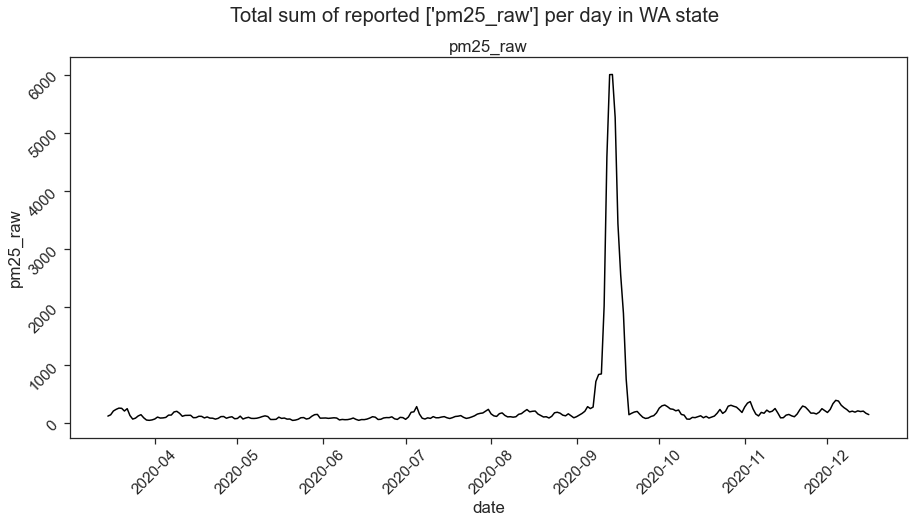

In [32]:
plot_time_series_for_state('WA', to_plot=['pm25_raw'])

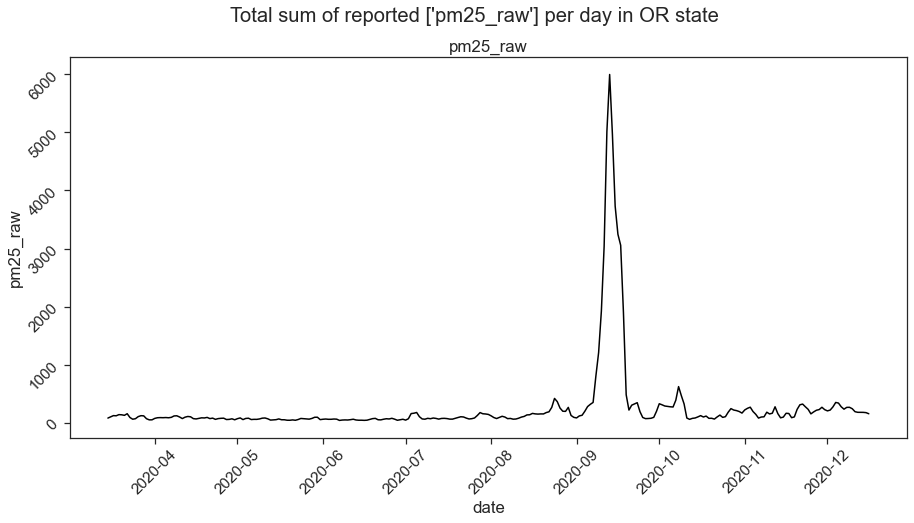

In [33]:
plot_time_series_for_state('OR', to_plot=['pm25_raw'])

Observation:
The data shows that there is spike in pm25_raw values around September. Again, as already previously mentioned, the data shows the presence of **waves** (or trend) which is common across all the sites

### Time series of cases/deaths for top county ranked by sum of cases/deaths/population

In the plot below, I compare PM2.5 time series for the top 5 counties ranked by population (the ranking can be changed  in the function to *cases* and *deaths*). I have places side-by-side the PM2.5 series and the history counterparts and makes the wildfire days to show that indeed there is significant difference in PM2.5 values observed in year 2020 compared to the previous year (historical) value.

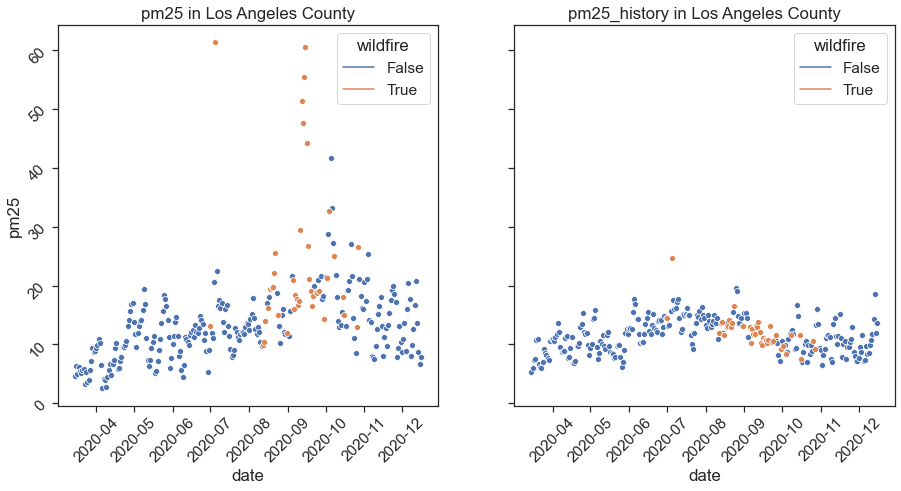

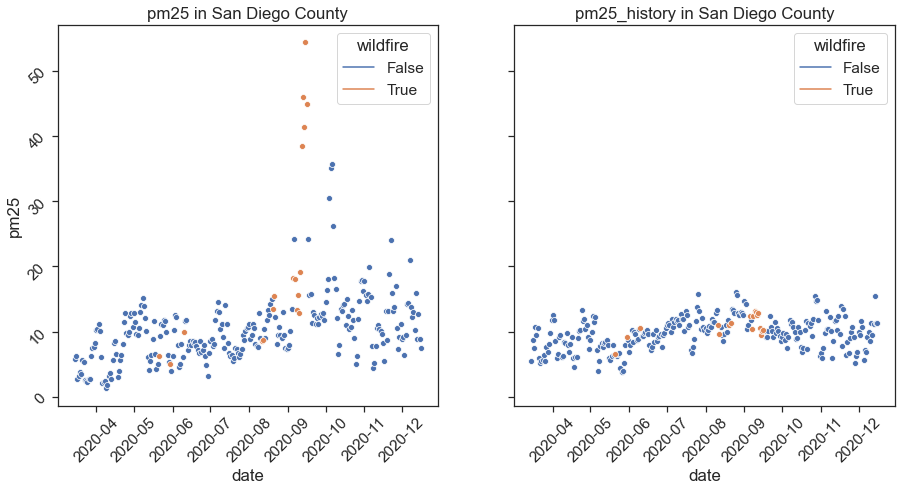

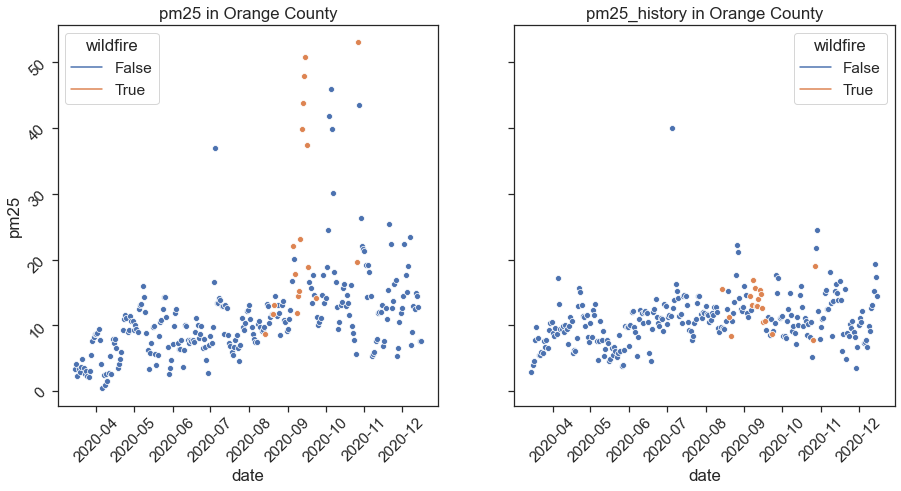

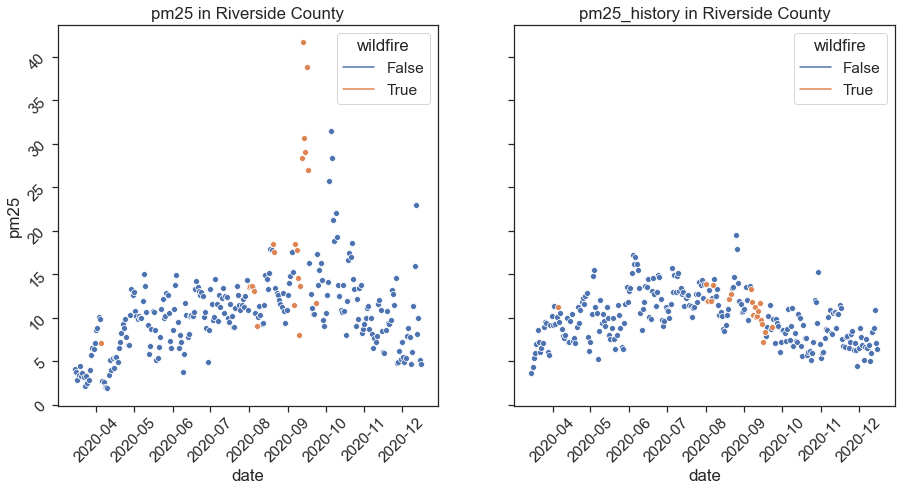

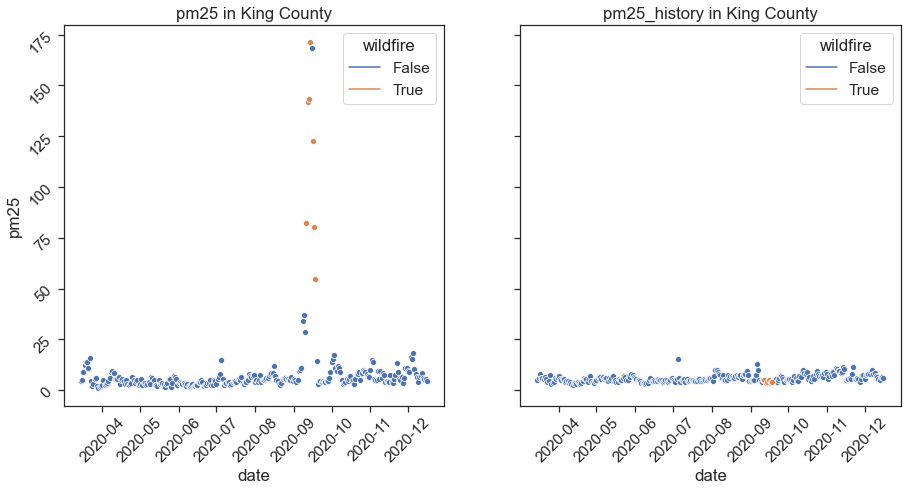

In [34]:
plot_top_counties_time_series('population', to_plot=['pm25', 'pm25_history'], sharey=True)


# 4. Weather

**tmmx**: temperature (max)

**rmax**: relative humidity (max)

**sph**: specific humidity

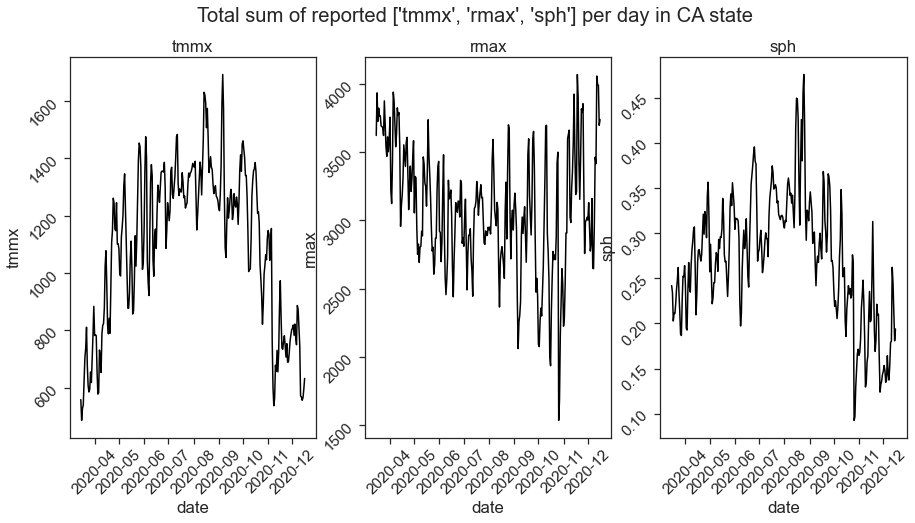

In [35]:
plot_time_series_for_state('CA', to_plot=['tmmx', 'rmax', 'sph'])

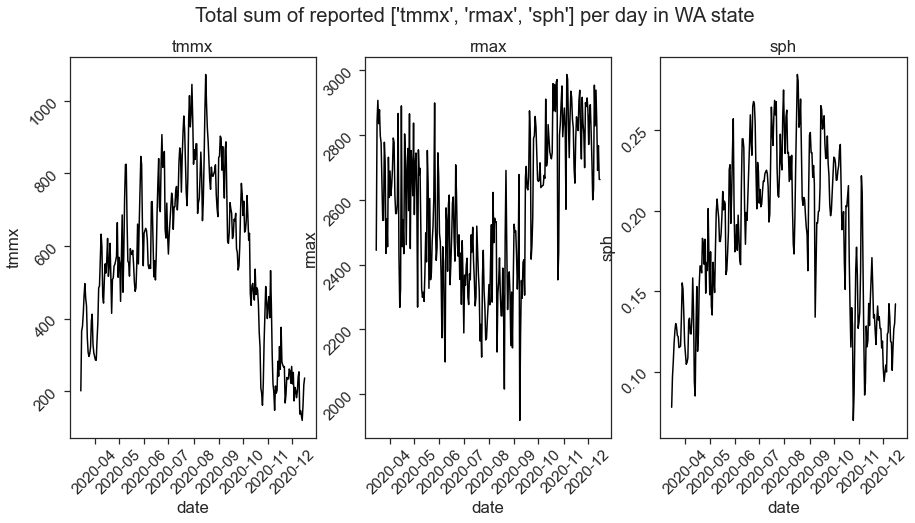

In [36]:
plot_time_series_for_state('WA', to_plot=['tmmx', 'rmax', 'sph'])

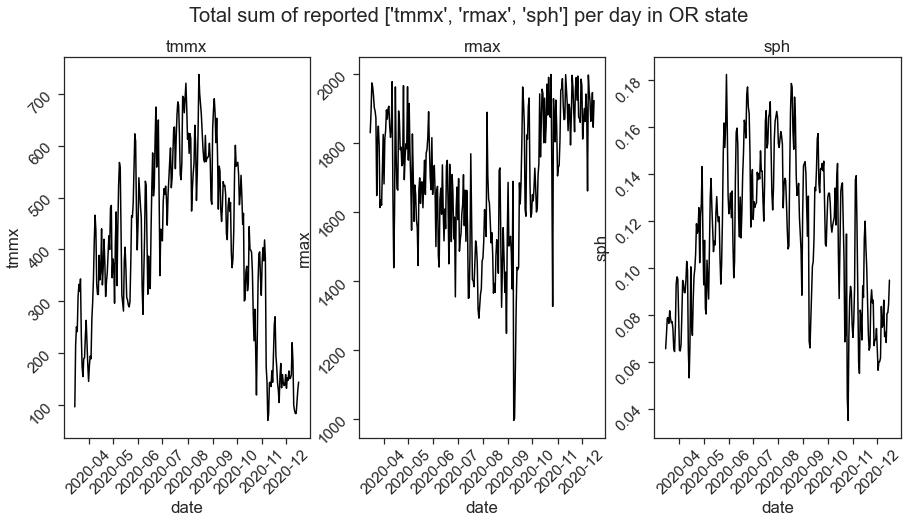

In [37]:
plot_time_series_for_state('OR', to_plot=['tmmx', 'rmax', 'sph'])

Observation
- Both temperature and specific hummidity climax around the same periods with the PM2.5. The same period correspond to a wave of rising Covid-19 cases and deaths

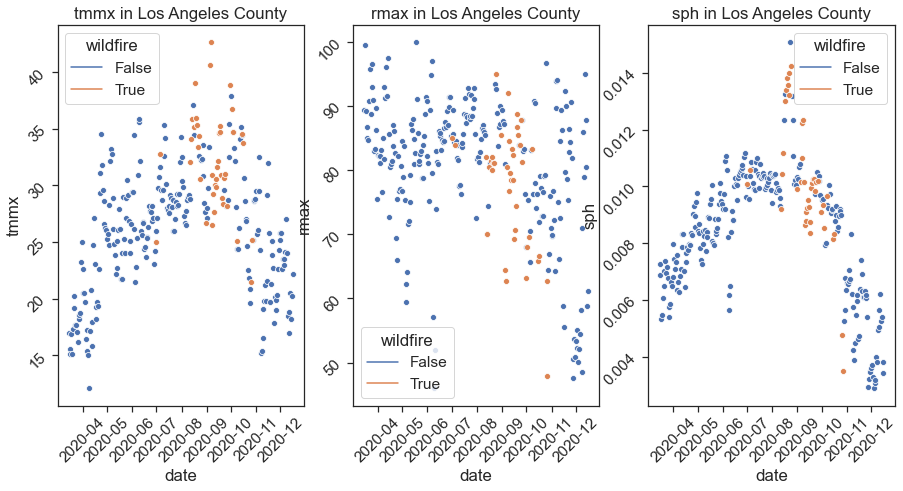

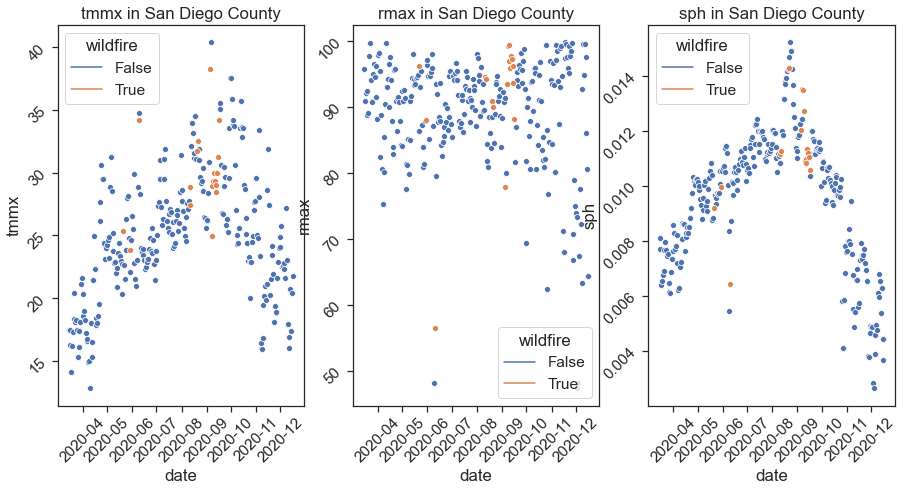

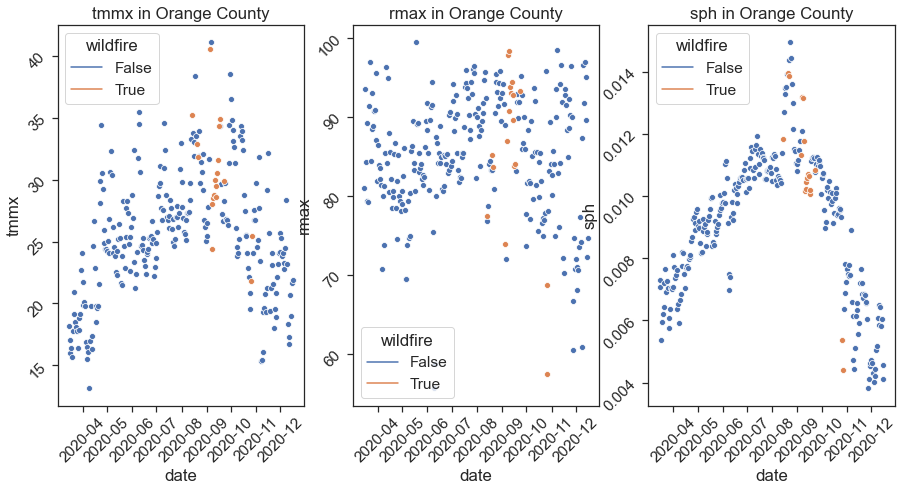

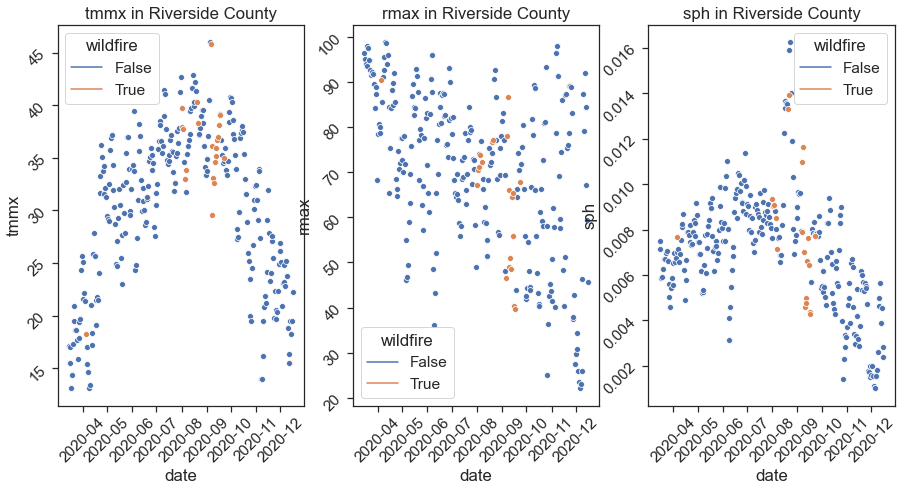

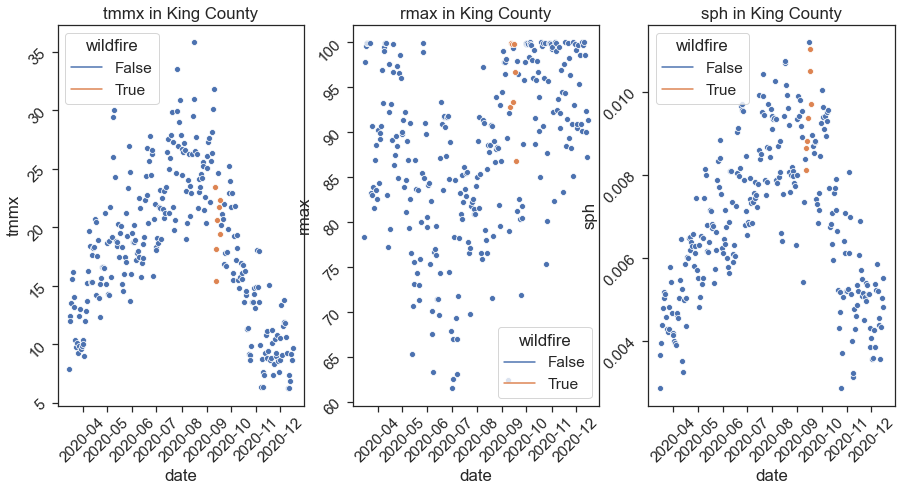

In [38]:
plot_top_counties_time_series('population', to_plot=['tmmx', 'rmax', 'sph'])

Observation

- Wildfire days occur on the around peak temperature and humidity periods

# Mobility

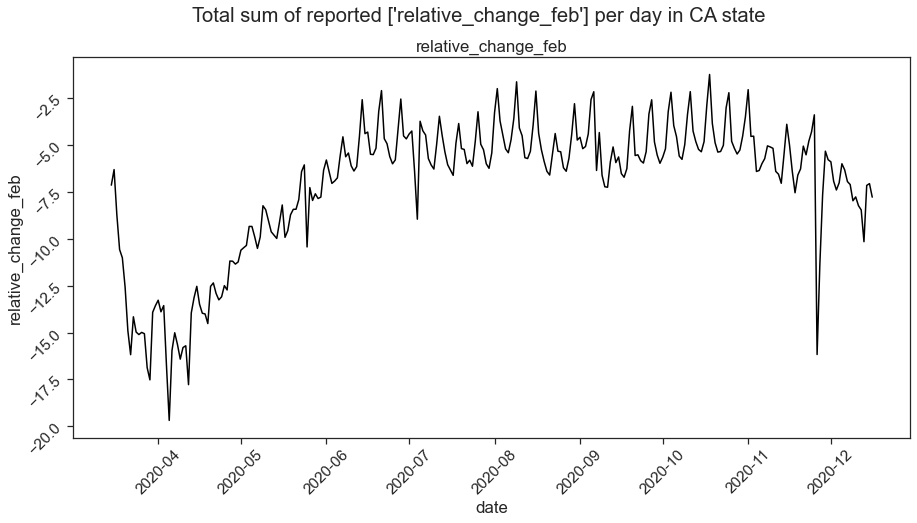

In [39]:
plot_time_series_for_state('CA', to_plot=['relative_change_feb'])

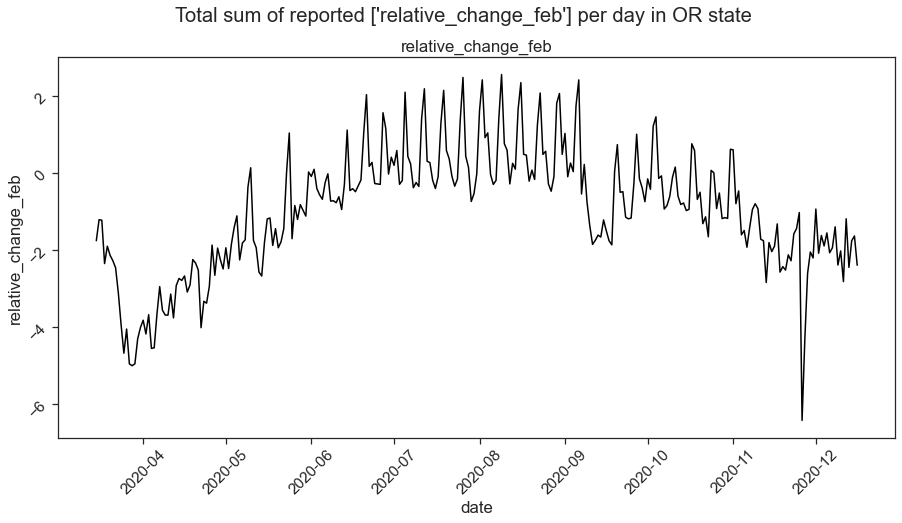

In [40]:
plot_time_series_for_state('OR', to_plot=['relative_change_feb'])

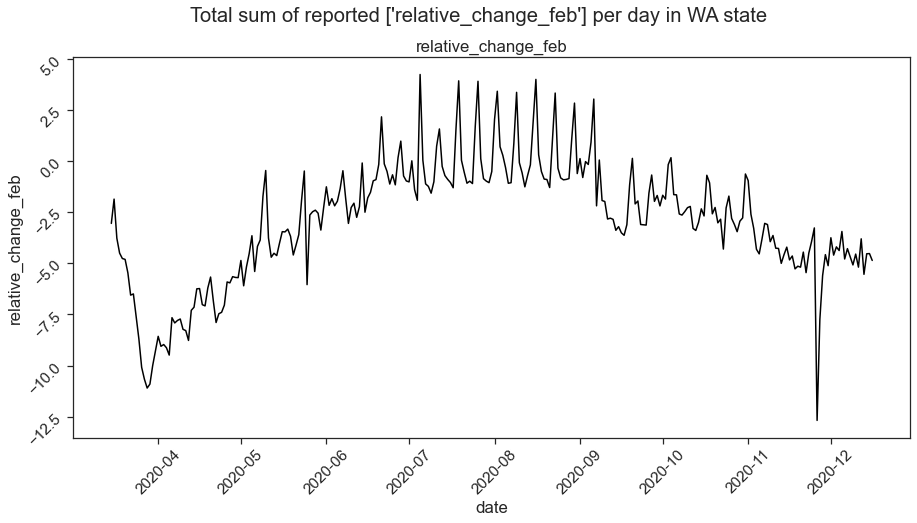

In [41]:
plot_time_series_for_state('WA', to_plot=['relative_change_feb'])

Observation:
    
- Similar pattern between all states 

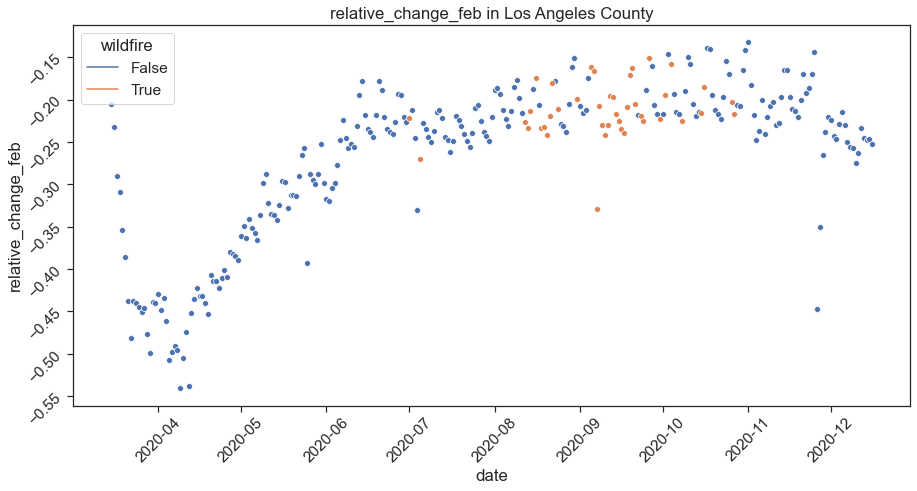

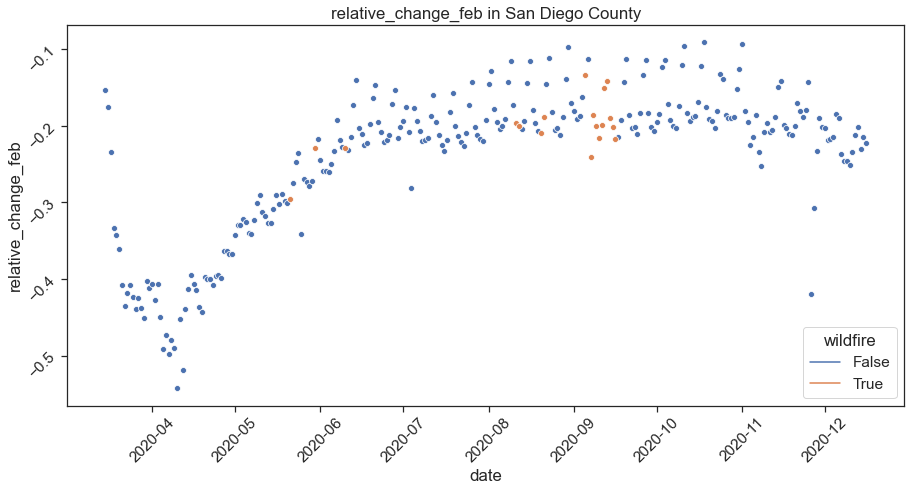

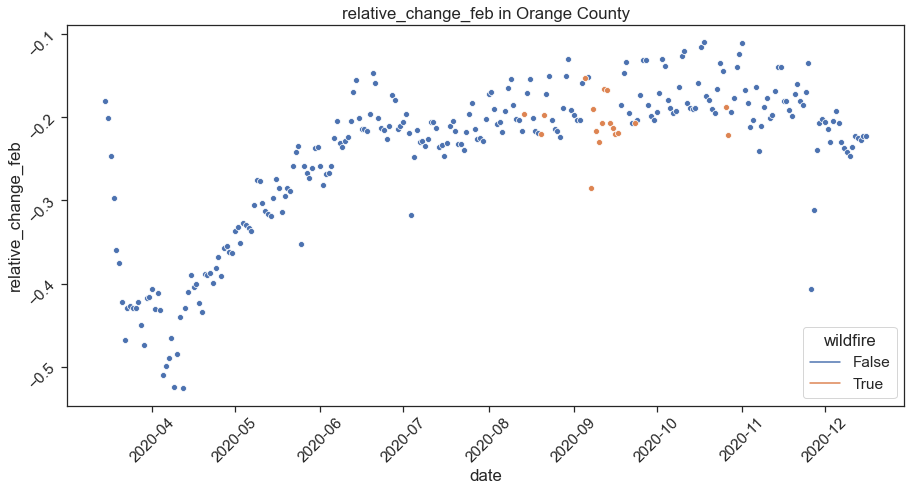

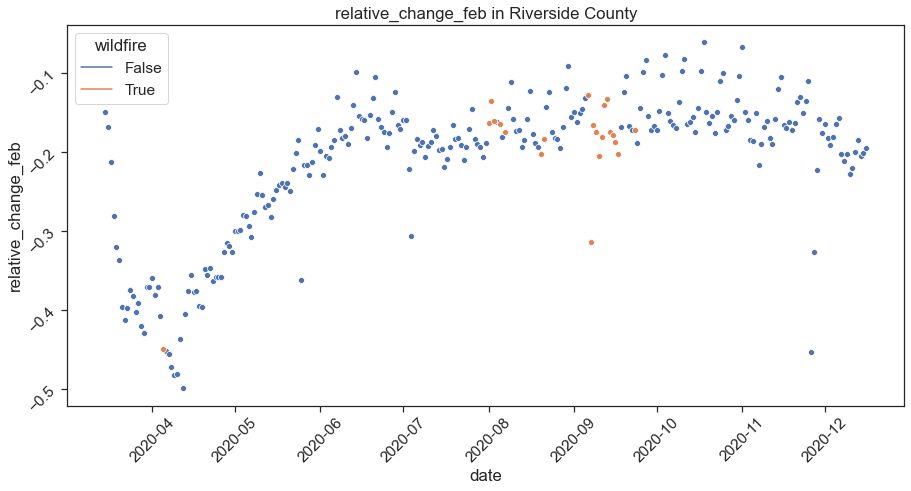

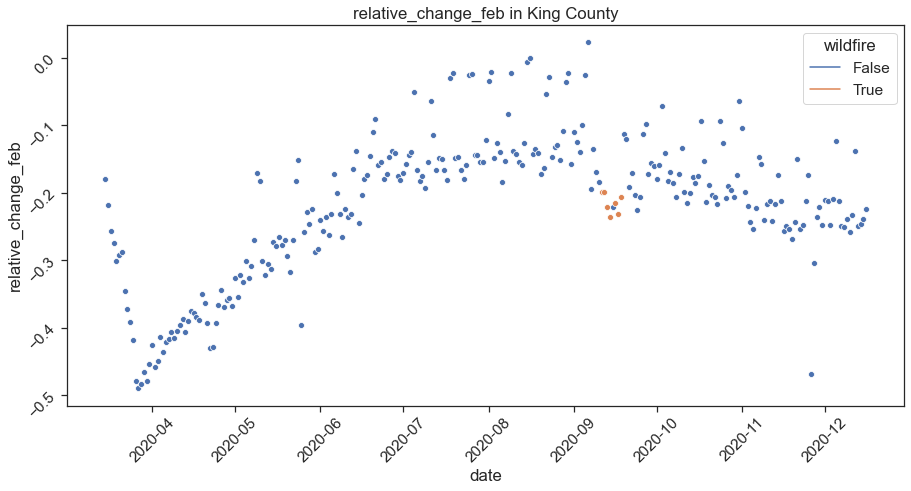

In [42]:
plot_top_counties_time_series('population', to_plot=['relative_change_feb'])

# Check for collinearity in variables (Covid-19 cases, deaths, pm2.5, temperature, humidity) using linear correlation matrix

In [43]:
corr_variables = ['date', 'cases', 'deaths', 'pm25', 'tmmx', 'sph', 'relative_change_feb']

In [44]:
def plot_corr_matrix(variables=corr_variables, factor='population', n=5):
    
    top_n_counties = get_top_counties(factor, n=n)
    top_data_state = data[data['County'].isin(top_n_counties)]
    
    #fig.suptitle(f'Distribution of Covid-19 cases and deaths for top {n} counties with highest {factor} in {state} state')
    
    for county in top_n_counties:
        series_county = top_data_state[top_data_state['County'] == county]
        series_county = series_county.sort_values('date')
        series_county = series_county[variables]
        series_county = series_county.rename(columns={'tmmx': 'temperature', 'sph': 'specific humidity', 'relative_change_feb': 'mobility' }, inplace=False)
        corr = series_county.corr()
        plt.title(county)
        sns.heatmap(corr, cmap="Greens",annot=True)
        plt.show()

The plot is obtained for the top 5 counties ranked by population below. As can be seen, there is potential for colinearity between specific humidity and temperature

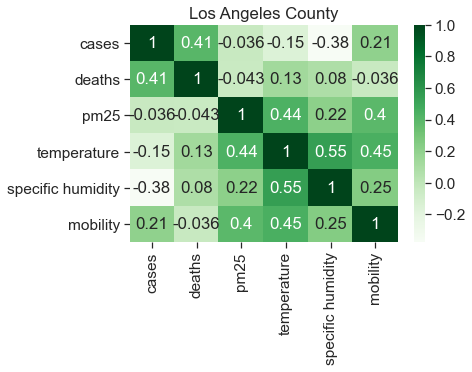

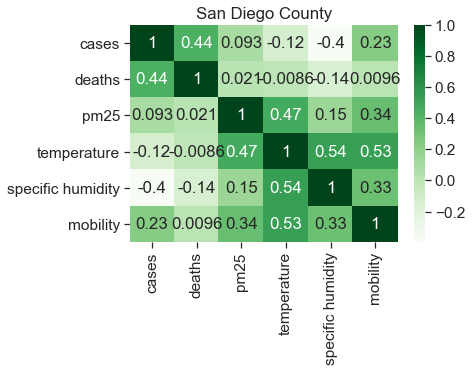

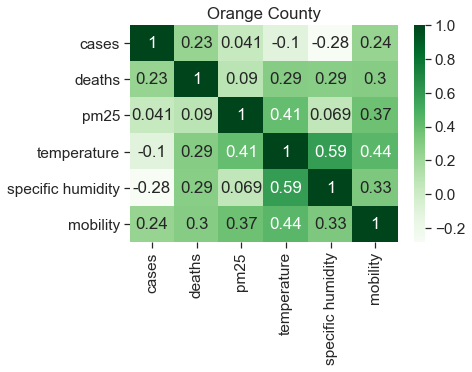

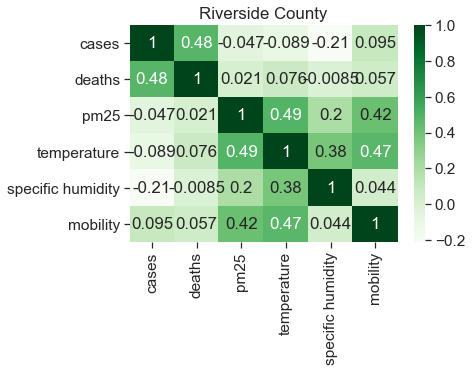

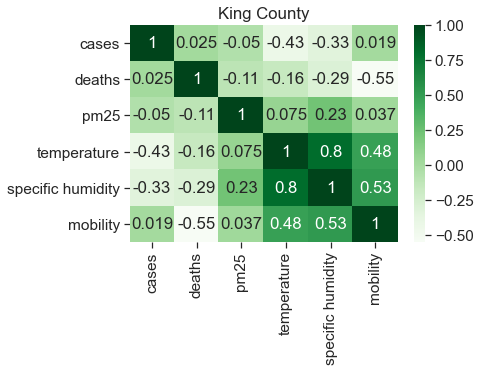

In [45]:
plot_corr_matrix()

# Summary

This analysis has been stopped at exploration stage due the time contraint for the deliverable that triggered this task.

The following information can be summarized from the exploration done above:

- The data covers 277 days in total, starting from 2020-03-15 to 2020-12-16
- 250 PM2.5 values are missing, hence there is need to handle missing data. This can be done in a couple of ways including ommission, interpolation, among others.
- The Covid-19 cases and deaths at macro-level (aggregating at state level) and micro-level (county) do display some ways which can be analysed using seasonality and trends analysis.
- PM2.5 on wildfire days in year 2020 was higher than in previous years.
- Wildfire days mostly appear around periods of high temeprature and specific humidity, as expected.
- It doesn't appear that there is multicollinearity among the Covid-19 cases, deaths, amount of PM2.5 and also the other confounding variables.
- Sparsity of the response variables: There are only about 20.99% nonzero death days reported in the data across all sites considered. Sparsity thus should be an important consideration for this study. Any model applied to the data must be chosen with consideration given to response data sparsity.

# Recommendation for reproducibility

- The repository presents the data in good condition. This helps with reproducibility. However, data documentation could be improved. It appears to be that columns names like `cummu_cases`, `cummu_deaths`, `tmmx`, `sph`, `md`, etc, are not intuitively relatable, or, in some cases, could be overloaded. For example, with the assumption that `cummu_cases` implies cummulative deaths, then one could ask: spatial or temporal cummulation? Over what time period? I spent a bit a time having to understand the codebase (looking line-by-line) to be able to extract these information.

- It wasn't also obvious that the temperature (`tmmx`) had been converted to celcius until I checked in the preprocessing code resident [here](https://github.com/xiaodan-zhou/covid_wildfire/blob/3724d9921e575b3ae362f9b51c0b32a6c74c24cc/src/data_preprocessing/get_weather.py). Units could also be included in the data documentation to improve rapid reproducibility.